In [41]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import tfz
from utils import plot_mfs

%matplotlib inline
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (10.5, 6)

In [43]:
SUBJECT = 'all'
ARCHITECTURE = '3-3-2-2-2-3-3'

arch_file = 'fcs-description-{}-{}.csv'.format(SUBJECT, ARCHITECTURE)
outp_file = 'fcs-outputs-{}-{}.csv'.format(SUBJECT, ARCHITECTURE)

In [44]:
VARIABLES = (
    'Leader distance', 'Next TLS distance', 'Next TLS green',
    'Next TLS yellow', 'Next TLS red', 'Speed', 'Speed to leader',
)
VARS = [''.join(s[:1].upper() + s[1:] for s in i.split(' ')) for i in VARIABLES]
DOMS = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 20), (-20, 20)]

## Mejor arquitectura

### Particiones

In [45]:
row = pd.read_csv(arch_file).iloc[-1]
variables_values = []
for variable in VARS:
    keys = [c for c in row.keys() if c.startswith('tfz/var/' + variable)]
    variables_values.append({
        k.split('/')[-1]: row[k] for k in keys
    })

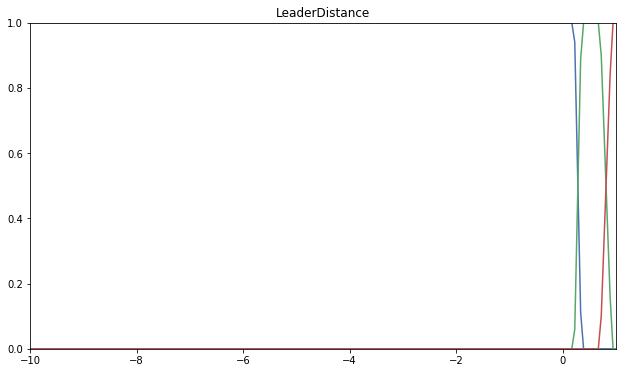

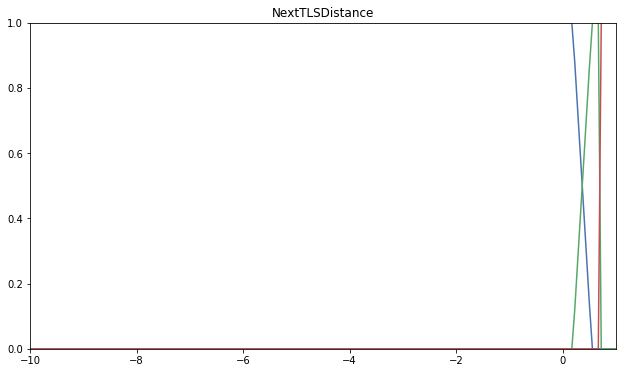

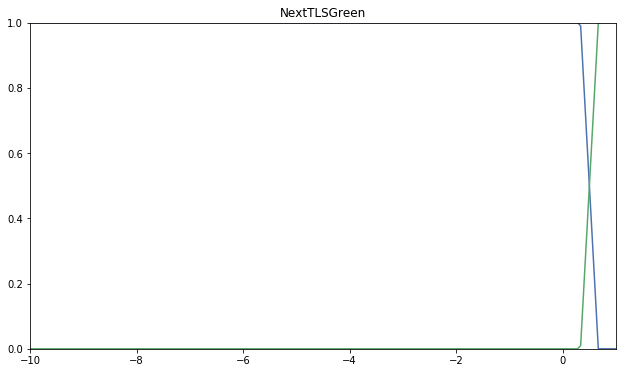

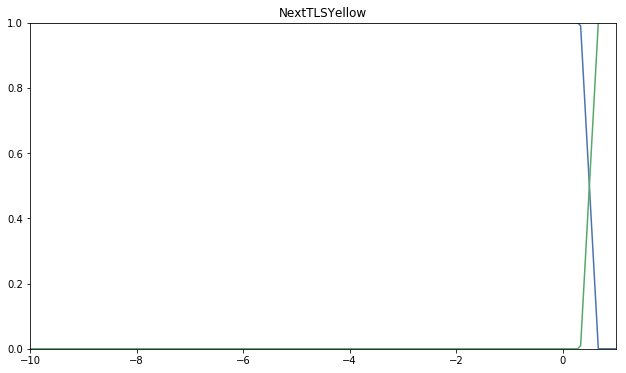

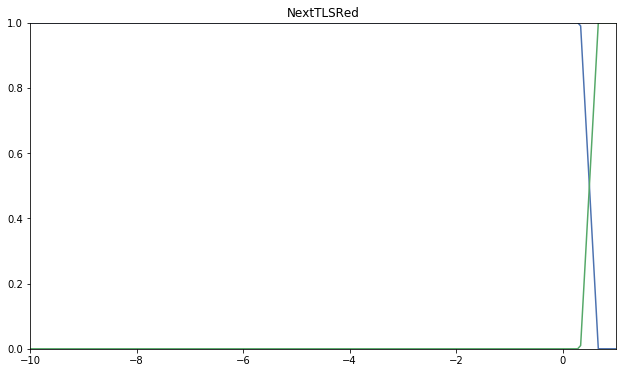

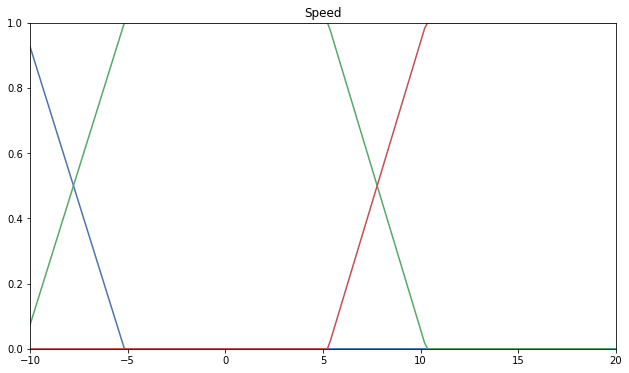

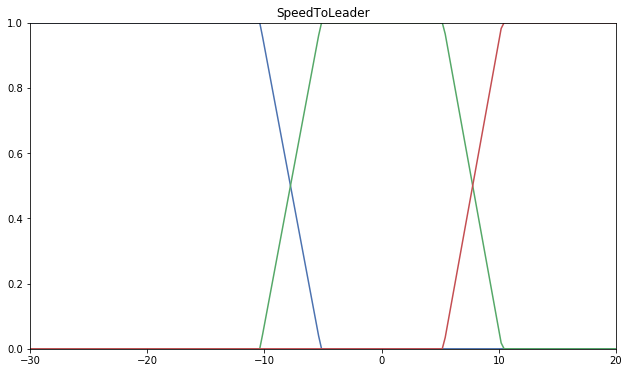

In [48]:
for i, (name, desc, domain) in enumerate(zip(VARS, variables_values, DOMS)):
    tf.reset_default_graph()

    for k, v in desc.items():
        desc[k] = np.float32(v)
    
    # Input data
    x = tf.placeholder(dtype=tf.float32)
    
    # Variables
    base = tf.constant(desc['b'], dtype=tf.float32)
    next_fs_starting_point = base + desc['s0']
    
    num_fs = ((len(desc) - 1) // 2) + 1
    mfs = []
    for i in range(num_fs):
        if i == 0:
            mf = tfz.slope_desc(x, next_fs_starting_point, desc['s1'])
        elif i == num_fs - 1:
            last = len(desc) - 2
            mf = tfz.slope_asc(x, next_fs_starting_point, desc['s{}'.format(last)])
        else:
            sta = ['s' + str(i) for i in range(i * 2 - 1, i * 2 + 2)]
            mf = tfz.trapezoid(x, next_fs_starting_point, desc[sta[0]], desc[sta[1]], desc[sta[2]])
            next_fs_starting_point += desc[sta[0]] + desc[sta[1]]

        mfs.append(mf)

    min_x, max_x = min(domain), max(domain)
    X = np.reshape(np.linspace(min_x, max_x, 200), (-1, 1))

    with tf.Session() as session:
        fig, ax = plt.subplots(1, 1)
        ax.set_title(name)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(0, 1)

        for Y in session.run(mfs, feed_dict={x: X}):
            ax.plot(X, Y)